# Advanced RAG techniques.

Large Language Models (LLMs) and Retrieval-Augmented Generative (RAG) models represented cutting-edge advancements in natural language processing (NLP) and AI research.  LLMs have demonstrated remarkable capabilities in understanding and generating human-like text across various domains. These models are pre-trained on large corpora of text data and fine-tuned for specific tasks, enabling them to perform tasks like text generation, translation, summarization, and more with impressive accuracy. The implications of LLMs are vast, ranging from revolutionizing content generation to improving conversational AI and customer service applications.

However, even if the original training data sources for an LLM are suitable for one's needs, it is challenging to maintain relevancy over time. RAG or Retrieval Augmented Generation allows developers to provide the latest research, statistics, or news to the generative models. RAG models combine the strengths of generative models with the factual accuracy of retrieved information, enhancing the relevance and coherence of generated text.

How RAG works:


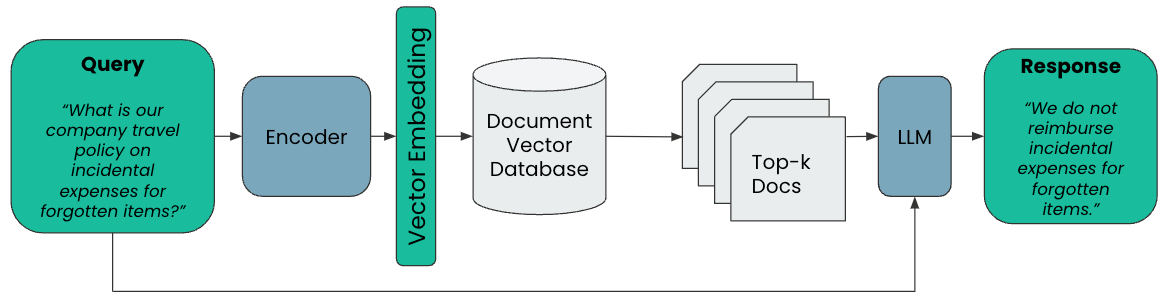

In the RAG models we augment LLMs capabilities with additional information from selected documents. We encode our documents with a vector embedding and store the result in a database. When we receive a user's query, we apply the same vector embedding to it and then retrieve the documents from our database that most closely match the query. We, then, send the query and the retrieved documents to an LLM that returns a response to the user's query.

## Basic RAG

In this section we review how a basic RAG  model works. We will store Alphabet's annual report for 2023 in the Chroma database, and will ask our model various questions about the report.

In [1]:
import textwrap

In [2]:
wrapper = textwrap.TextWrapper(width=70)

In [3]:
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 6.2 MB/s eta 0:00:00


We read in the report's text.

In [4]:
from pypdf import PdfReader

reader = PdfReader("/content/drive/MyDrive/Advanced Retrieval for AI/20230203_alphabet_10K.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

print(wrapper.fill(pdf_texts[3]))

Note About Forward-Looking Statements This Annual Report on Form 10-K
contains forward-looking statements within the meaning of the Private
Securities Litigation Reform Act of 1995. These include, among other
things, statements regarding: •the growth of our business and revenues
and our expectations about the factors that influence our success  and
trends in our business; •fluctuations in our revenues and  margins and
various factors contributing to such fluctuations; •our expectation
that the continuing shift from an offline to online world will
continue to benefit our business; •our expectation that the portion of
our revenues that we derive from non-advertising revenues will
continue to  increase and may affect our margins; •our expectation
that our traffic acquisition costs (TAC) and the associated TAC rate
will fluctuate, which could  affect our overall margins; •our
expectation that our monetization trends will fluctuate, which could
affect our revenues and margins; •fluctuations

In [5]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


We split our text into chunks using LangChain's Recursive Character Splitter.

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

In [7]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

•fluctuations in our revenues, as well as the change in paid clicks and cost-per-click and the change in 
impressions and cost-per-impression, and various factors contributing to such fluctuations;
•our expectation that we will continue to periodically review, refine, and update our methodologies for 
monitoring, gathering, and counting the number of paid clicks and impressions;
•our expectation that our results will be affected by our performance in international markets as users in 
developing economies increasingly come online;
•our expectation that our foreign exchange risk management program will not fully offset our net exposure to 
fluctuations in foreign currency exchange rates;
•the expected variability of gains and losses related to hedging activities under our foreign exchange risk 
management program;
•the amount and timing of revenue recognition from customer contracts with commitments for performance

Total chunks: 384


We will use Sentence Transformers for vector embeddings of our texts.

In [8]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

We use Sentence Transformers to encode our text as vectors. However each input chunk into Sentence Transformers must not exceed 256 tokens, so we use Sentence Transformer Token Text Splitter to split our text chunks further.

In [9]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

note about forward - looking statements this annual report on form 10 - k contains forward - looking statements within the meaning of the private securities litigation reform act of 1995. these include, among other things, statements regarding : • the growth of our business and revenues and our expectations about the factors that influence our success and trends in our business ; • fluctuations in our revenues and margins and various factors contributing to such fluctuations ; • our expectation that the continuing shift from an offline to online world will continue to benefit our business ; • our expectation that the portion of our revenues that we derive from non - advertising revenues will continue to increase and may affect our margins ; • our expectation that our traffic acquisition costs ( tac ) and the associated tac rate will fluctuate, which could affect our overall margins ; • our expectation that our monetization trends will fluctuate, which could affect our revenues and marg

We will use ChromaDB to store the vector representations of our texts.

In [10]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 4

In [11]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.015829764306545258, -0.01910567842423916, 0.025905797258019447, -0.02350509539246559, 0.046040140092372894, 0.0518057607114315, 0.01588379591703415, 0.04662001132965088, 0.06166938692331314, 0.01453842967748642, 0.010206090286374092, 0.11429557204246521, -0.03808052837848663, -0.06324752420186996, 0.03700197860598564, -0.010989267379045486, 0.0380009263753891, 0.023086832836270332, -0.03872789070010185, 0.06833026558160782, -0.00016307646001223475, 0.005505388602614403, 0.005965069867670536, 0.02518555335700512, -0.02850288338959217, -0.047133252024650574, -0.07238802313804626, 0.0172259658575058, -0.04529771953821182, -0.030233588069677353, -0.07940130680799484, 0.017957091331481934, 0.025036318227648735, 0.004829340614378452, 0.049246516078710556, -0.05169764161109924, -0.040392857044935226, 0.0059232087805867195, 0.017631933093070984, -0.012801488861441612, 0.005198150407522917, -0.12111865729093552, -0.06657954305410385, -0.02644060179591179, 0.02698267064988613, -0.0172479189

We initialize ChromaDB client and store the vector embeddings of our text chunks there.

In [12]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("alphabet_annual_report_2023", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

409

We retrieve 5 closest documents for the given query.

In [13]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(wrapper.fill(document))
    print('\n')

deferred revenue 635 774 367 net cash provided by operating activities
65, 124 91, 652 91, 495 investing activities


as revenue. we expect t o recognize approximately half of the revenue
backlog as revenues over the next 24 months with the remaining to be
recognized thereafter. revenue backlog includes related deferred
revenue currently recorded as well as amounts that will be invoiced in
future periods, and excludes contracts with an original expected term
of one year or less and cancellable contracts. deferred revenue we
record deferred revenues when cash payments are received or due in
advance of our performance, including amounts which are refundable.
deferred revenues primarily relate to google cloud and google other.
total deferred revenue as of december 31, 2021 was $ 3. 8 billion, of
which $ 2. 5 billion was recognized as revenues for the year ending
december 31, 2022. table of contents alphabet inc. 59


compensation expenses of $ 1. 8 billion, largely resulting from a 19 %
i

In [14]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00


We now initialize our LLM (gpt-3.5-turbo), pass the query and the 5 relevant documents, and obtain the answer to our query from the LLM.

In [15]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv('/content/drive/MyDrive/Advanced Retrieval for AI/.env')) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [16]:
def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [17]:
output = rag(query=query, retrieved_documents=retrieved_documents)

print(wrapper.fill(output))

Total revenue for the year was $282.8 billion.


## Pitfalls of retrieval

It often happens that whereas RAG can find similar documents to the query, these documents do not contain the answer. In this section we visualize the query and the retrieved documents using the UMAP package.


In [18]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [19]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [21]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 409/409 [08:16<00:00,  1.21s/it]


We visualize the projected embeddings of our texts.

(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

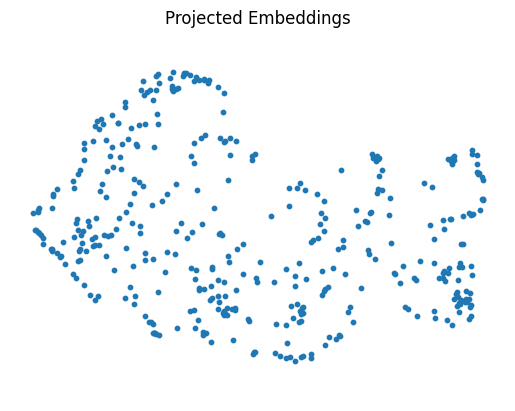

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

### Relevancy and Distraction



In [23]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(wrapper.fill(document))
    print('')

deferred revenue 635 774 367 net cash provided by operating activities
65, 124 91, 652 91, 495 investing activities

as revenue. we expect t o recognize approximately half of the revenue
backlog as revenues over the next 24 months with the remaining to be
recognized thereafter. revenue backlog includes related deferred
revenue currently recorded as well as amounts that will be invoiced in
future periods, and excludes contracts with an original expected term
of one year or less and cancellable contracts. deferred revenue we
record deferred revenues when cash payments are received or due in
advance of our performance, including amounts which are refundable.
deferred revenues primarily relate to google cloud and google other.
total deferred revenue as of december 31, 2021 was $ 3. 8 billion, of
which $ 2. 5 billion was recognized as revenues for the year ending
december 31, 2022. table of contents alphabet inc. 59

) ( 5, 980 ) comprehensive income $ 42, 134 $ 73, 777 $ 53, 992

compensat

In [24]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

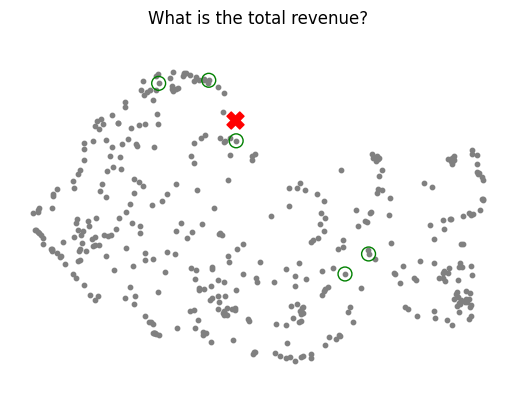

In [25]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

We note that some of the returned documents (green circles in the picture) are not particularly close to our query (red cross in the picture).

### Try another query

In [26]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(wrapper.fill(document))
    print('')

field of human endeavor. as an information and computer science
company, we will continue to be at the forefront of advancing the
frontier of ai. through our path - breaking and field - defining
research and development, we responsibly and boldly develop more
capable and useful ai every day. ai already powers google ’ s core
products that help billions of people every day and has been at the
foundation of our core ads quality systems for years, helping large
and small businesses all over the world to produce and run effective
and efficient ad campaigns that help grow their businesses. ai makes
it possible to search in new languages, with multiple inputs, such as
using images and text at the same time with the google app. some of
our most popular products at google — including lens and translate —
were built entirely using artificial intelligence technologies such as
optical character recognition and machine learning. google cloud
continues to build ai into numerous solutions that

moon

In [27]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

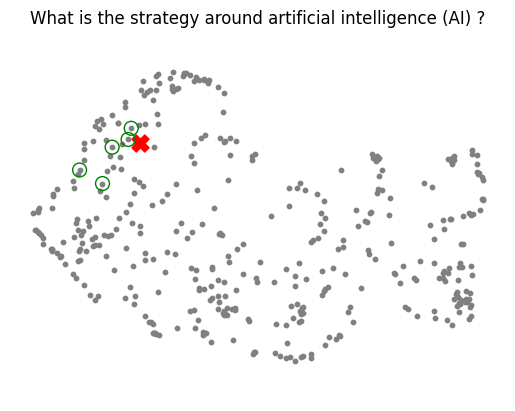

In [28]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In this case the returned documents are closer to the original query.

### Third query

In [29]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(wrapper.fill(document))
    print('')

laws and regulations may require us to make new capital investments,
build new products, and seek partners to deliver localized services in
other countries, and we may not be able to meet sovereign operating
requirements. within other bets, we are investing significantly in the
areas of health, life sciences, and transportation, among others.
these investment areas face intense competition from large,
experienced, and well - funded competitors, and our offerings, many of
which involve the development of new and emerging technologies, may
not be successful, or be able to compete effectively or operate at
sufficient levels of profitability. in addition, new and evolving
products and services, including those that use ai, require
significant investment and raise ethical, technological, legal,
regulatory, and other challenges, which may negatively affect our
brands and demand for our products and services. because all of these
investment areas are inherently risky, no assurance can

or bet

In [30]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

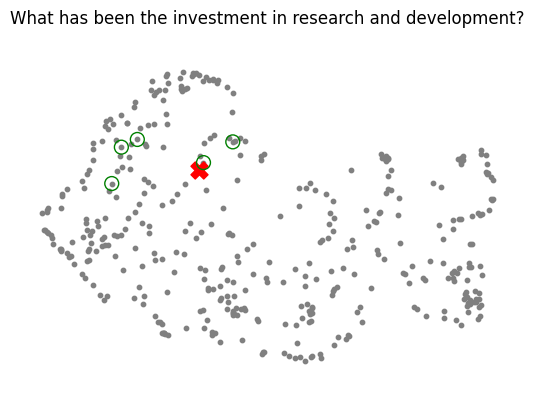

In [31]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

### Irrelevant query

In [32]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(wrapper.fill(document))
    print('')

can have fulfilling careers, and be happy, healthy, and productive. we
offer industry - leading benefits and programs to take care of the
diverse needs of our employees and their families, including
opportunities for career growth and development, resources to support
their financial health, and access to excellent healthcare choices.
our competitive compensation programs help us to attract and retain
top candidates, and we will continue to invest in recruiting talented
people to technical and non - technical roles, and rewarding them
well. we provide a variety of high quality training and support to
managers to build and strengthen their capabilities - – ranging from
courses for new managers, to learning resources that help them provide
feedback and manage performance, to coaching and individual support.
at alphabet we are committed to making diversity, equity, and
inclusion part of everything we do and to growing a

strategic investments contribute to the breadth and depth of our
off

In [33]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

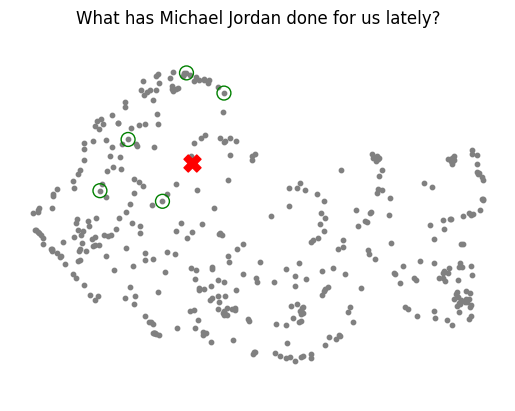

In [34]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

The irrelevant to query documents are called distractors. They distract the LLM model from answering the question, so the answer is suboptimal.The presence of distractors is hard to diagnose when building applications. To improve the model performance one can utilize query expansion.

## Query Expansion

There are two ways to expand a query:
1. have an LLM (ChatGPT) produce a hypothetical answer and add it to the original query.
2. ask a LLM (ChatGPT) to produce several queries similar to the original query and use all the queries.

We start with the first approach.

In [35]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [52]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(wrapper.fill(joint_query))

Was there significant turnover in the executive team? "In the past
fiscal year, our executive team experienced minimal turnover. There
were no changes in our CEO, CFO, or CTO positions. However, we did see
a rotation of one board member and the addition of a new Chief
Marketing Officer to our leadership team."


In [53]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(wrapper.fill(doc))
    print('')

item 10. directors, executive officers, and corporate governance 85
item 11. executive compensation 85 item 12. security ownership of
certain beneficial owners and management and related stockholder
matters85 item 13. certain relationships and related transactions, and
director independence 85 item 14. principal accountant fees and
services 85 part iv item 15. exhibits, financial statement schedules
86 item 16. form 10 - k summary 89 signaturestable of contents
alphabet inc. 2

note 11 of the notes to consolidated financial statements included in
item 8 of this annual report on form 10 - k for additional
information. • operating cash flow was $ 91. 5 billion for the year
ended december 31, 2022. • capital expenditures, which primarily
reflected in vestments in technical infrastructure, were $ 31. 5
billion for the year ended december 31, 2022. • as of december 31,
2022, we had 190, 234 employees. addition ally, looking ahead to
fiscal year 2023 : • in january 2023, we announced a reduc

In [54]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

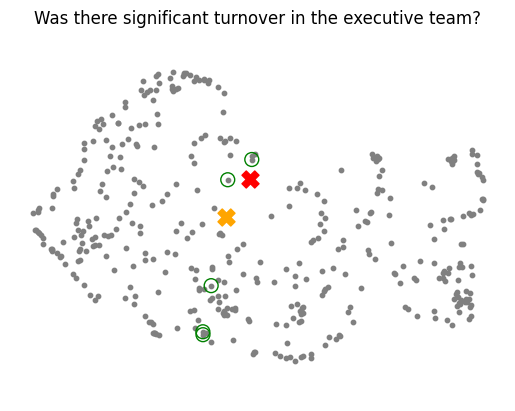

In [55]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Try another query

In [60]:
original_query = "What has been the investment in research and development?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(wrapper.fill(joint_query))

What has been the investment in research and development? In the
current fiscal year, our company has allocated $10 million towards
research and development initiatives. This investment is part of our
ongoing commitment to innovation and new product development to stay
competitive in the market and meet the evolving needs of our
customers. Our focus on research and development reflects our long-
term strategy to drive growth and maintain our position as a leader in
our industry.


In [61]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(wrapper.fill(doc))
    print('')

research and development the following table presents r & d expenses (
in millions, except percentages ) : year ended december 31, 2021 2022
research and development expenses $ 31, 562 $ 39, 500 research and
development expenses as a percentage of revenues 12 % 14 % r & d
expenses increased $ 7. 9 billion from 2021 to 2022 primarily driven
by an increase in compensation expenses of $ 5. 4 billion, largely
resulting from a 21 % increase in average headcount, and an increase
in third - party service fees of $ 704 million. sales and marketing
the following table presents sales and marketing expenses ( in
millions, except percentages ) : year ended december 31, 2021 2022
sales and marketing expenses $ 22, 912 $ 26, 567 sales and marketing
expenses as a percentage of revenues 9 % 9 % sales and marketing
expenses increased $ 3. 7 billion from 2021 to 2022, primarily driven
by an increase in

* $ 100 invested on december 31, 2017 in stock or in index, including
reinvestment of dividends. copy

In [62]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

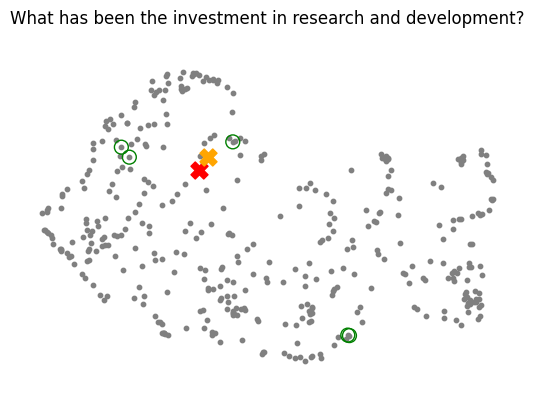

In [63]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

We see that the two queries are close, and we have one document that is  close to both queries.

### Third query

In [64]:
original_query = "What is the strategy around artificial intelligence (AI) ?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(wrapper.fill(joint_query))

What is the strategy around artificial intelligence (AI) ? The company
is strategically focused on leveraging artificial intelligence (AI) to
enhance operational efficiency and improve decision-making across
various aspects of our business. By integrating AI technologies into
our processes, we aim to streamline workflows, optimize resource
allocation, and identify new opportunities for growth. Our AI strategy
involves investing in talent with expertise in AI, partnering with
leading technology providers, and continuously exploring innovative
applications of AI to drive sustainable competitive advantages in the
market.


In [65]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(wrapper.fill(doc))
    print('')

moonshots many companies get comfortable doing what they have always
done, making only incremental changes. this incrementalism leads to
irrelevance over time, especially in technology, where change tends to
be revolutionary, not evolutionary. people thought we were crazy when
we acqu ired youtube and android and when we launched chrome, but
those efforts have matured into major platforms for digital video and
mobile devices and a safer, popular browser. we continue to look
toward the future and to invest for the long term within each of our
segments. as we said in the original founders'letter, we will not shy
away from high - risk, high - reward projects that we believe in, as
they are the key to our long - term success. the power of ai we
believe that ai is a foundational and transformational technology that
will provide compelling and helpful benefits to people and society
through its capacity to assist, complement, empower, and inspire
people in almost every

field of human endeavo

In [66]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

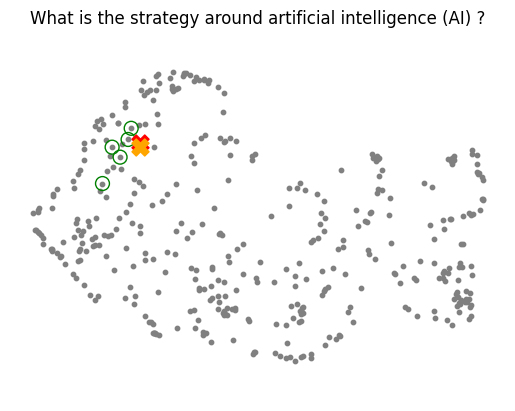

In [67]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

We note that the retrieved documents appear closer together and closer to the queries, than when we used the original query only.

### Expansion with multiple queries

In [68]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [69]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- What were the key revenue streams for the company?
- How did changes in pricing strategy impact revenue growth?
- Were there any significant acquisitions that contributed to revenue increase?
- Did new product launches have a noticeable impact on revenue?
- How did changes in market demand influence revenue growth?


In [70]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(wrapper.fill(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
compensation expenses of $ 1. 8 billion, largely resulting from a 19 %
increase in average headcount, and an increase in advertising and
promotional activities of $ 1. 3 billion. general and administrative
the following table presents general and administrative expenses ( in
millions, except percentages ) : year ended december 31, 2021 2022
general and administrative expenses $ 13, 510 $ 15, 724 general and
administrative expenses as a percentage of revenues 5 % 6 % general
and administrative expenses increased $ 2. 2 billion from 2021 to
2022. the increase was primarily driven by an increase in compensation
expenses of $ 1. 1 billion, largely resulting from a 21 % increase in
average headcount, and an increase in third - party services fees of $
815 million. in addition, there was a $ 551 million increase to the
allowance for credit losses for accounts receivable, as the prior year
comparab

In [71]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


In [72]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09451625198125835,
 6.862327690422535)

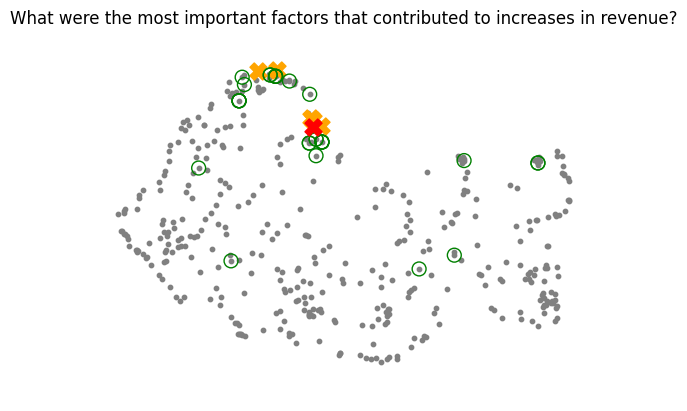

In [73]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Try another query

In [74]:
original_query = "What has been the investment in research and development?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How has the investment in research and development changed over the past three years?
- What percentage of total revenue is allocated to research and development?
- Are there any new innovative products or projects resulting from the research and development investments?
- How does the company track the return on investment for research and development spending?
- What impact has research and development had on the company's competitive position in the market?


In [75]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(wrapper.fill(doc))
        print('')
    print('-'*100)

Query: What has been the investment in research and development?

Results:
laws and regulations may require us to make new capital investments,
build new products, and seek partners to deliver localized services in
other countries, and we may not be able to meet sovereign operating
requirements. within other bets, we are investing significantly in the
areas of health, life sciences, and transportation, among others.
these investment areas face intense competition from large,
experienced, and well - funded competitors, and our offerings, many of
which involve the development of new and emerging technologies, may
not be successful, or be able to compete effectively or operate at
sufficient levels of profitability. in addition, new and evolving
products and services, including those that use ai, require
significant investment and raise ethical, technological, legal,
regulatory, and other challenges, which may negatively affect our
brands and demand for our products and services. because a

In [76]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


In [77]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

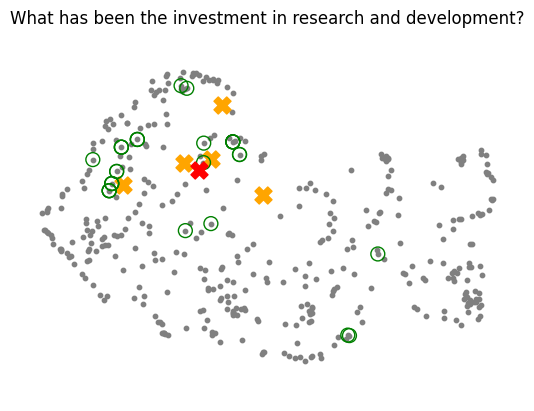

In [78]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Cross-encoder Re-ranking

Another technique one can use to improve the relevance of retrieved documents is cross-encoder re-ranking. Cross-encoder is an LLM that outputs a relevance score between the query and the document. We then can choose the documents with the highest relevance score. One can use cross-encoder re-ranking in two ways: retrieve more documents in response to our query and then rank them (re-ranking the long tail), or augment our query with similar queries and then rank all the responses.



### Re-ranking the long tail

In [79]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(wrapper.fill(document))
    print('')

laws and regulations may require us to make new capital investments,
build new products, and seek partners to deliver localized services in
other countries, and we may not be able to meet sovereign operating
requirements. within other bets, we are investing significantly in the
areas of health, life sciences, and transportation, among others.
these investment areas face intense competition from large,
experienced, and well - funded competitors, and our offerings, many of
which involve the development of new and emerging technologies, may
not be successful, or be able to compete effectively or operate at
sufficient levels of profitability. in addition, new and evolving
products and services, including those that use ai, require
significant investment and raise ethical, technological, legal,
regulatory, and other challenges, which may negatively affect our
brands and demand for our products and services. because all of these
investment areas are inherently risky, no assurance can

or bet

In [80]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [81]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
-5.919445
-5.0602393
-2.7146728
-10.105211
-4.1993084
-6.7629094
-8.431683
-0.6517673
-10.135794
-11.043375


In [82]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
8
3
5
2
1
6
7
4
9
10


### Re-ranking with the query expansion

In [83]:
original_query = "What has been the investment in research and development?"
generated_queries = [
    "What percentage of revenue was spent on research and development?",
    "What are the key research and development projects the company has been working on?",
    "How has the investment in research and development changed over the past few years?",
    "What impact has the company's research and development initiatives had on its products or services?",
    "What are the future plans for research and development spending?"]

In [84]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [85]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [86]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [91]:
scores = cross_encoder.predict(pairs)

In [92]:
print("Scores:")
for score in scores:
    print(score)

Scores:
-11.229699
-10.135794
-5.0602393
-11.295565
-3.312916
-11.052573
-10.038315
-10.105211
-11.329539
-11.204065
-10.978003
-11.331598
-8.431682
-8.500861
-11.205106
-2.714672
-11.20018
-11.302736
-10.923539
-4.1993055
-11.221213
-11.234182
-11.248205
-10.995325
-10.337488
-0.65176815
-11.383425
-11.077218
-5.9194446
-11.087074
-11.043375
-11.012638
-10.811781
-11.204796
-11.041076
-6.762908


In [93]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
25
15
4
19
2
28
35
12
13
6
7
1
24
32
18
10
23
31
34
30
5
27
29
16
9
33
14
20
0
21
22
3
17
8
11
26


We will visualize the query and the re-ranked documents.

In [96]:
new_order = np.argsort(scores)[::-1]
new_top_5 = new_order[:5]


In [97]:
original_query_embedding = embedding_function([original_query])
generated_query_embeddings = embedding_function(generated_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_generated_queries = project_embeddings(generated_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


In [98]:
top_ranked_documents = []
for elt in new_top_5:
    top_ranked_documents.append(unique_documents[elt])


In [99]:
for doc in top_ranked_documents:
    print(wrapper.fill(doc))
    print('\n')

our products and services. the margins on these revenues vary
significantly and are generally lower than the margins on our
advertising revenues. in particular margin s on our hardware products
adversely affect our consolidated margins due to pressures on pricing
and higher cost of sales. • as we continue to serve our users and
expand our businesses, we will invest heavily in operating and capital
expenditures. we continue to make significant research and development
investments in areas of strategic focus as we seek to develop new,
innovative offerings and improve our existing offerings across our
businesses. we also expect to continue to invest in our technical
infrastructure, including servers, network equipment, and data
centers, to support the growth of our business and our long - term
initiatives, in part icular in support of ai. in addition acquisitions
and


research and development the following table presents r & d expenses (
in millions, except percentages ) : year ended dec

In [100]:
top_ranked_embeddings = embedding_function(top_ranked_documents)
#top_ranked_embeddings = np.array(top_ranked_embeddings)
project_top_ranked = project_embeddings(top_ranked_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


(-0.1889473468065262,
 10.271590080857276,
 0.09706096500158307,
 6.808888716995716)

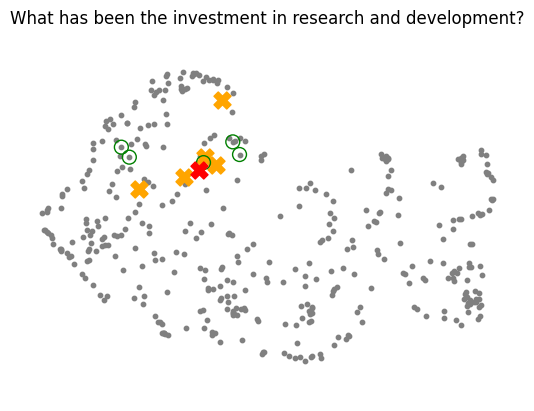

In [101]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_generated_queries[:, 0], project_generated_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(project_top_ranked[:, 0], project_top_ranked[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Embeddings adaptors

Embeddings adaptors is a technique to alter the embedding of the query to improve the retrieval results. We will build a linear adaptor. A linear adapter is simply a linear transformation that specifically transforms the query embedding while keeping document embeddings fixed. It can be used on top of any existing embeddings model. The linear adapter is trained using a loss term that penalizes the ground-truth (question, context) pairs for being far apart.

In [102]:
import torch

### Create a dataset

We first create a dataset to train our adaptor. We have an LLM generate 15 short questions one might ask about a company's annual report, and retrieve the documents from our database related to these queries. We then have an LLM evaluate pairs of query-document for relevance giving a score of 1 if the response is relevant and -1 otherwise. We generate a dataset that contains the queries embeddings, the documents embeddings and the 1, -1 labels.

In [103]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [104]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What are the company's total revenues for the year?
2. What is the net income of the company?
3. How much debt does the company have on its balance sheet?
4. What is the company's cash position at the end of the year?
5. What are the company's operating expenses for the year?
6. How much did the company spend on research and development?
7. What is the company's current ratio?
8. What is the company's return on equity?
9. How much did the company spend on capital expenditures?
10. What is the company's earnings per share?
11. What is the company's dividend payout ratio?
12. What are the company's long-term liabilities?
13. How much does the company have in inventory?
14. What are the company's gross profit margins?
15. What is the company's free cash flow for the year?


In [105]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [106]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [107]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [108]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [109]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:07<00:00,  4.51s/it]


In [110]:
len(adapter_labels)

150

Convert data to Torch tensors

In [111]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [112]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

### Setting up the model

We train a linear model (find the adaptor-matrix) on top of queries embeddings to maximize similarity between the updated queries embeddings and document embeddings.

In [122]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [123]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [124]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [125]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


In [126]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.44464874267578125


In [127]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

We can think of the adaptor matrix as squizing or stretching space for the dimensions most relevant to our query. We visualize how the adapter matrix scales the vector consisting of all 1s.

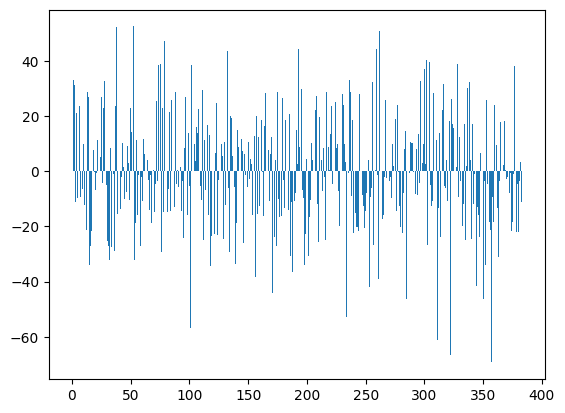

In [128]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [129]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


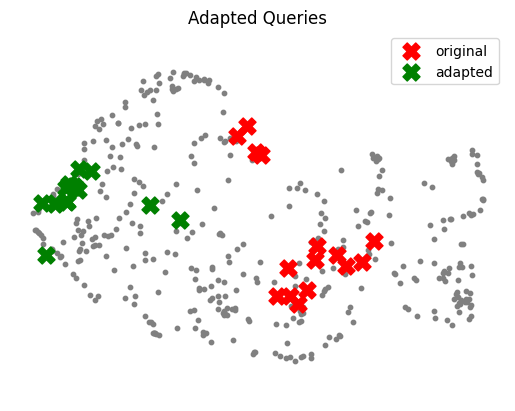

In [130]:
# Plot the original and adapted queries in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

We visualize the original embeddings of the queries in red, and adapted embeddings in green. We see that the adapted embeddings appear closer to each other. This might allow us to transform our embedding representations into a new latent space that is optimized for retrieval over our specific data and queries.